In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# Carga de todos los csv en la carpeta 'mediciones'
files = os.listdir('mediciones')

# Lista de dataframes
dfs = [pd.read_csv('mediciones/' + file) for file in files]

# Nombre de las futuras columnas
columns = [f.replace(".csv", "") for f in files ]


In [ ]:
# Verifico que todos los dataframes tengan la misma columna de tiempo
time_cols = [df['time'].tolist() for df in dfs]
for i, time_col in enumerate(time_cols):
    if time_col != time_cols[0]:
        print(f'Dataframe {i} es diferente!')
        break
    else:
        print(f'Df {i} vs 0: Todas las filas son iguales')

Df 0 vs 0: Todas las filas son iguales
Df 1 vs 0: Todas las filas son iguales
Df 2 vs 0: Todas las filas son iguales
Df 3 vs 0: Todas las filas son iguales
Df 4 vs 0: Todas las filas son iguales
Df 5 vs 0: Todas las filas son iguales
Df 6 vs 0: Todas las filas son iguales
Df 7 vs 0: Todas las filas son iguales


In [ ]:
# Concateno todos los dataframes sobre una única columna time
df = pd.concat([df['(V)'] for df in dfs], axis=1)
df.columns = columns
df['time'] = time_cols[0]

# Convierto la columna time en indice
df.set_index('time', inplace=True)

# Reordeno columnas usando parte numerica del nombre
columns = sorted(columns, key=lambda x: int(x[:-2]))
df = df[columns]

df.head()

,181mm,261mm,552mm,644mm,743mm,839mm,927mm,1042mm
time,,,,,,,,
0.000,0.355050,0.347517,0.357561,0.360072,0.360072,0.360072,0.357561,0.355050
0.005,0.355050,0.355050,0.365094,0.357561,0.367605,0.360072,0.357561,0.357561
0.010,0.355050,0.347517,0.355050,0.367605,0.365094,0.362583,0.357561,0.357561
0.015,0.357561,0.339984,0.357561,0.362583,0.357561,0.357561,0.350028,0.357561
0.020,0.347517,0.355050,0.357561,0.362583,0.355050,0.360072,0.365094,0.357561


In [ ]:
# 1 A
# Vemos los valores de 0 y 1
print(df['181mm'][0.0])
print(df['181mm'][2.0])

0.35505
4.458015


In [ ]:
# 1 B

# Funcione auxiliares para bajar la frecuencia artificialmente

def is_close_to_integer(x, tolerance=1e-4):
    return np.isclose(x, round(x), atol=tolerance)

def is_multiple(x, multiple):
    return is_close_to_integer(x/multiple)

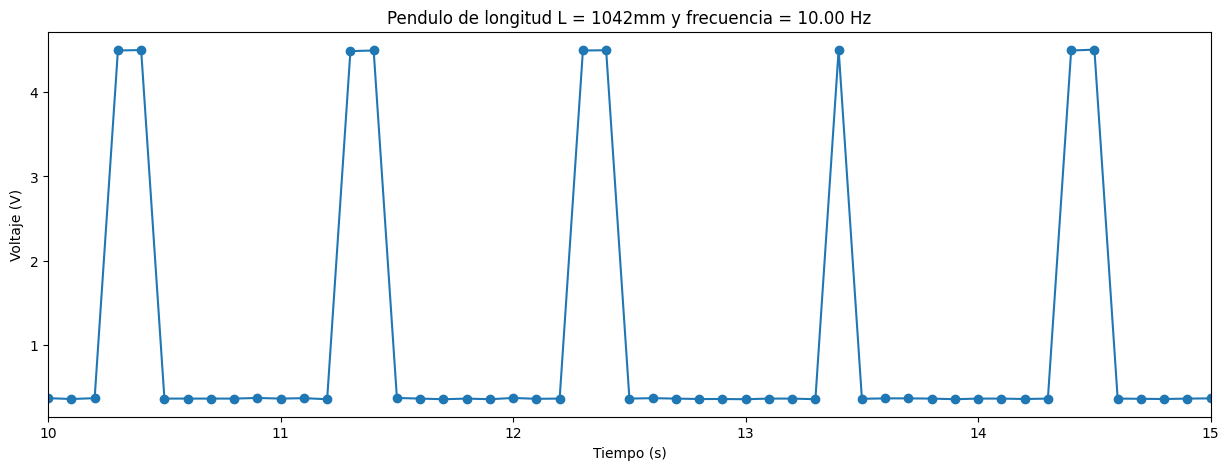

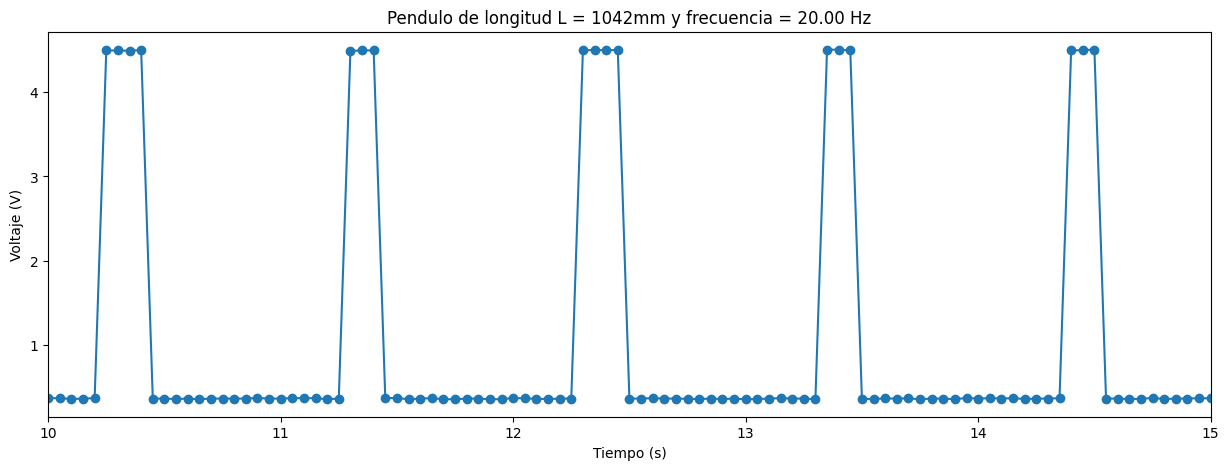

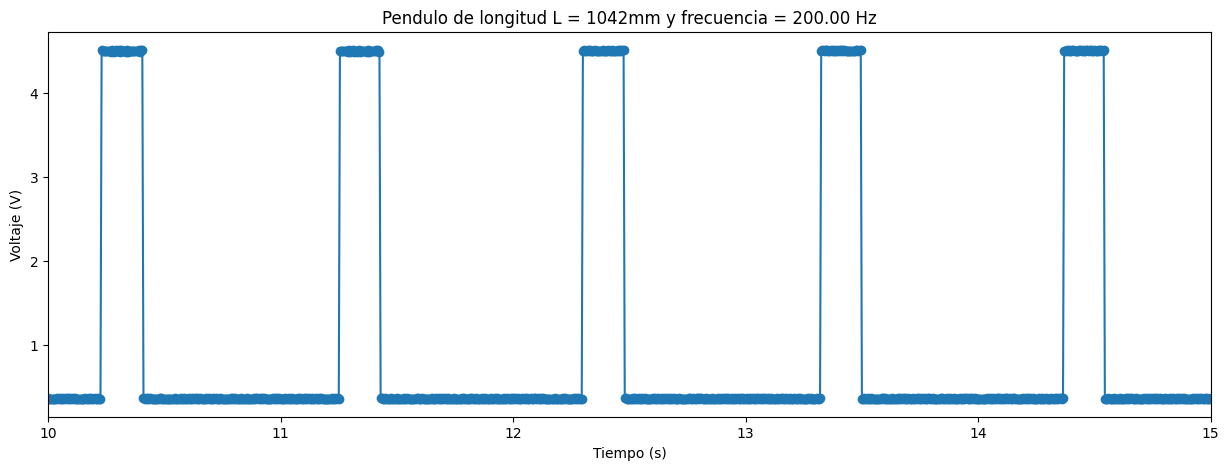

In [ ]:
freqs = [1/10, 1/20, 1/200]

for freq in freqs:
    a = (df['1042mm'].index).tolist()
    result = [is_multiple(num, freq) for num in a]
    df_low_freq = df[result]

    fig = plt.figure(figsize=(15,5))
    df_low_freq['1042mm'].plot(style="-o")
    plt.title(f"Pendulo de longitud L = {'1042mm'} y frecuencia = {1/freq:.2f} Hz")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Voltaje (V)")
    plt.xlim([10, 15])
    plt.show()

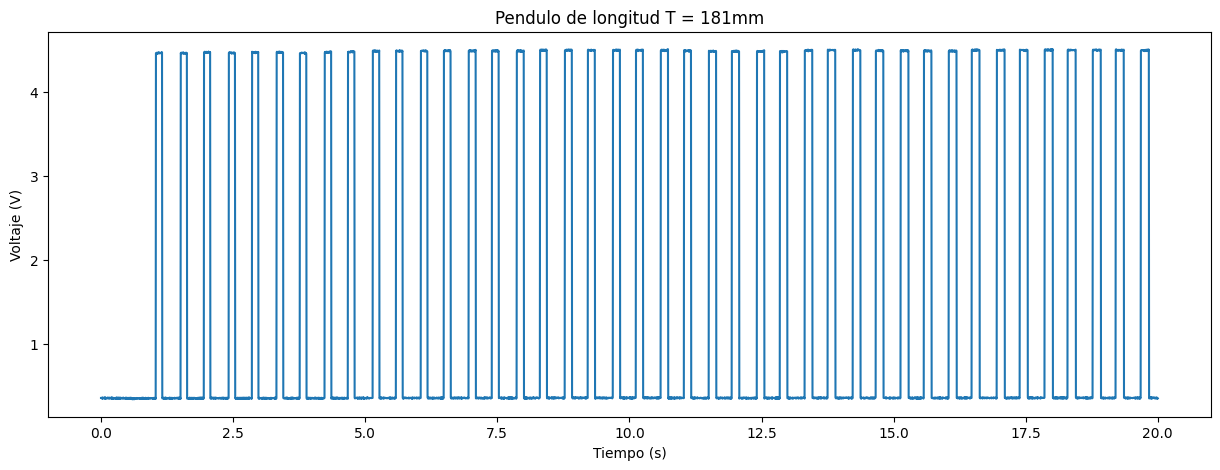

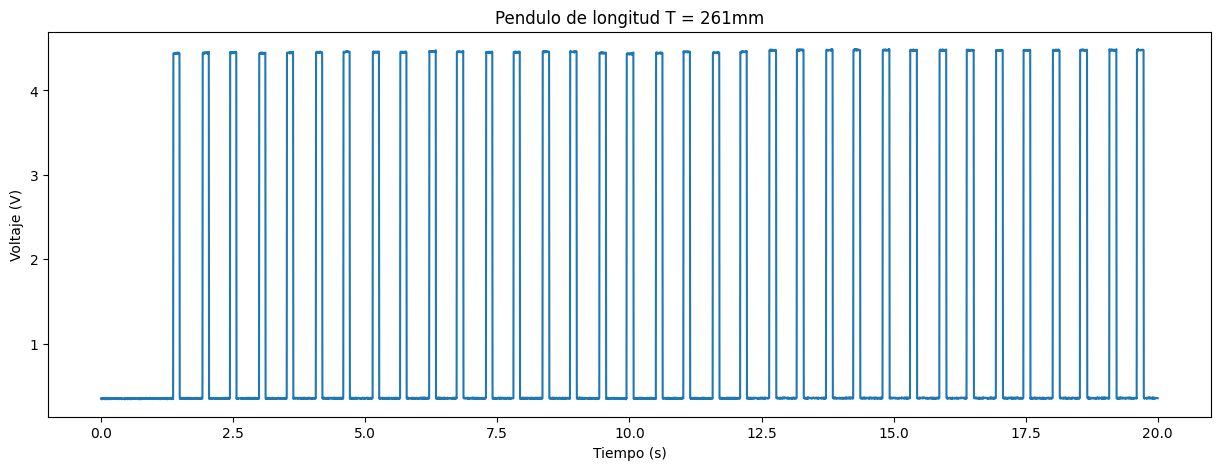

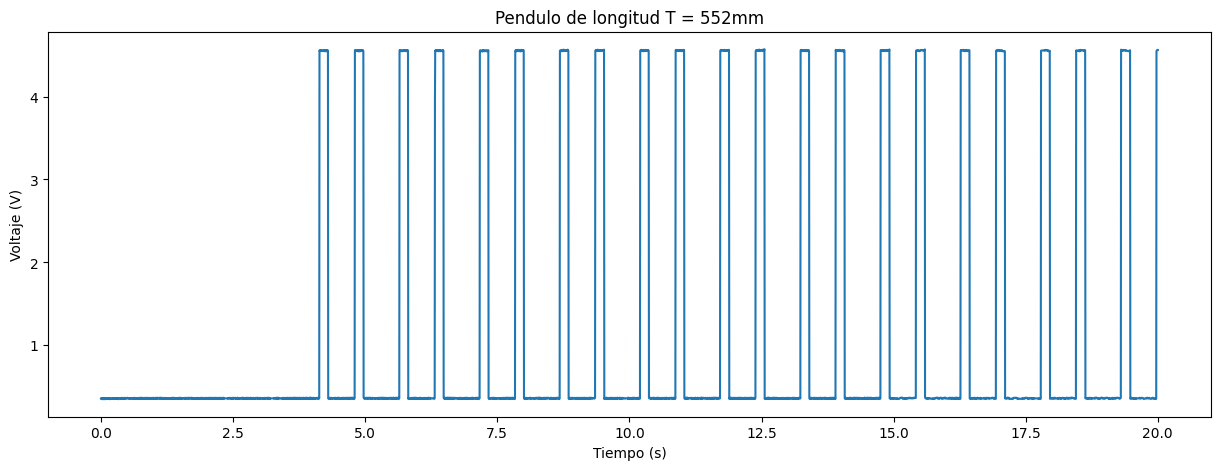

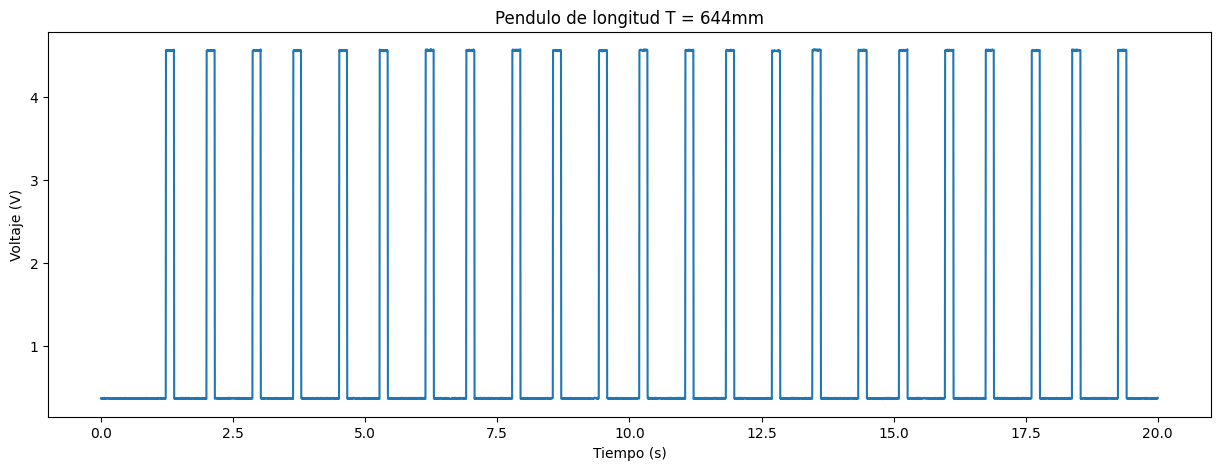

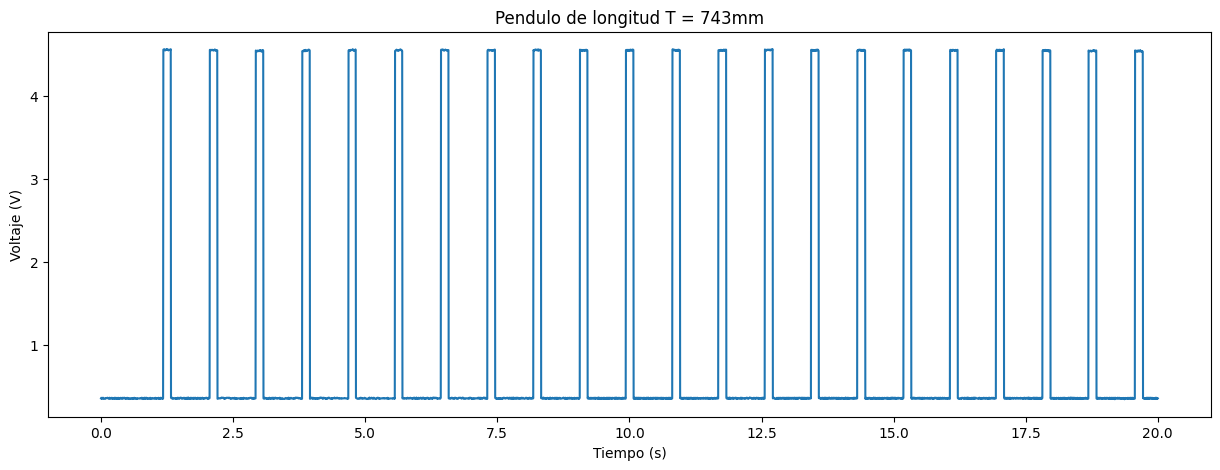

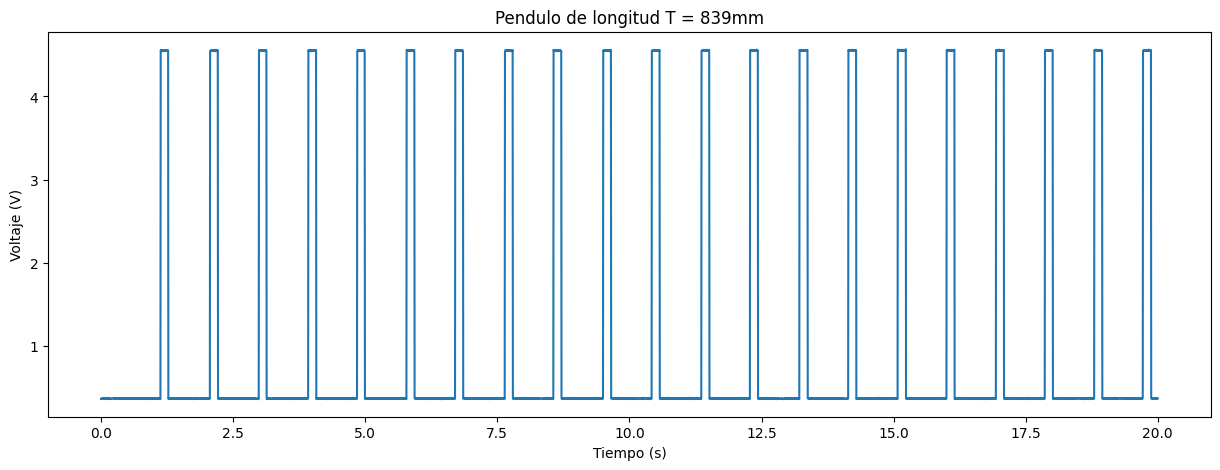

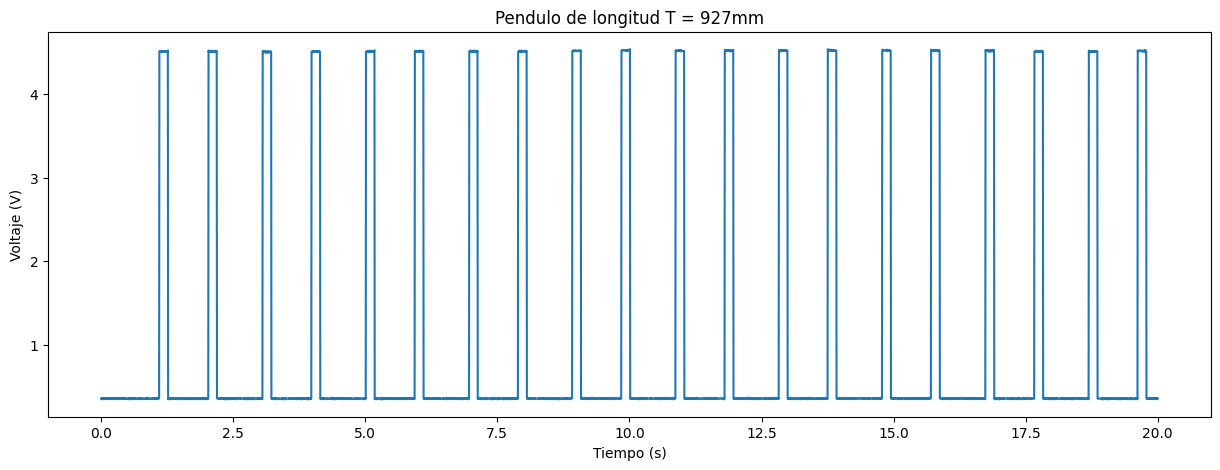

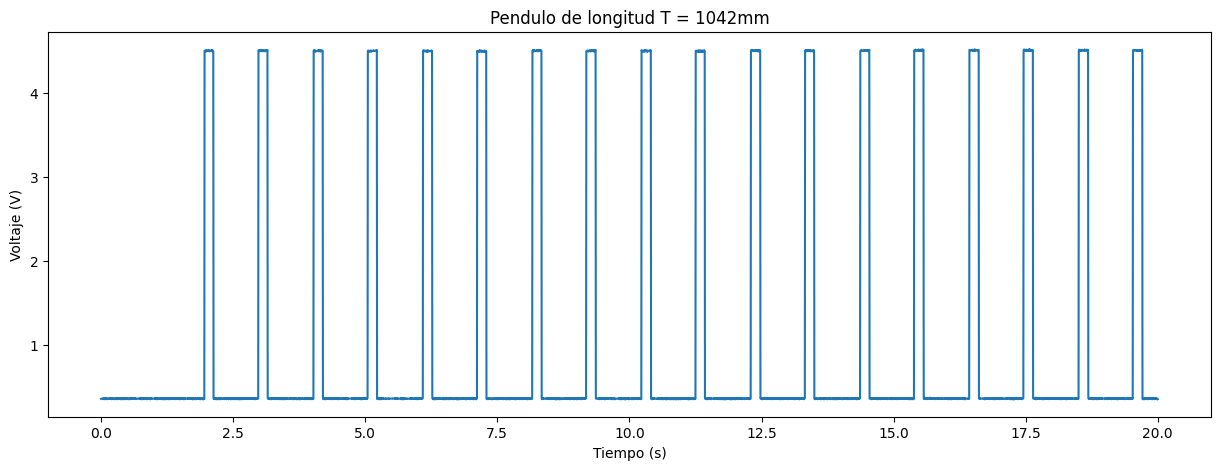

In [ ]:
# Grafico todas las señales
for c in columns:
    plt.figure(figsize=(15,5))
    df[c].plot()
    plt.title(f"Pendulo de longitud T = {c}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Voltaje (V)")
    plt.show()

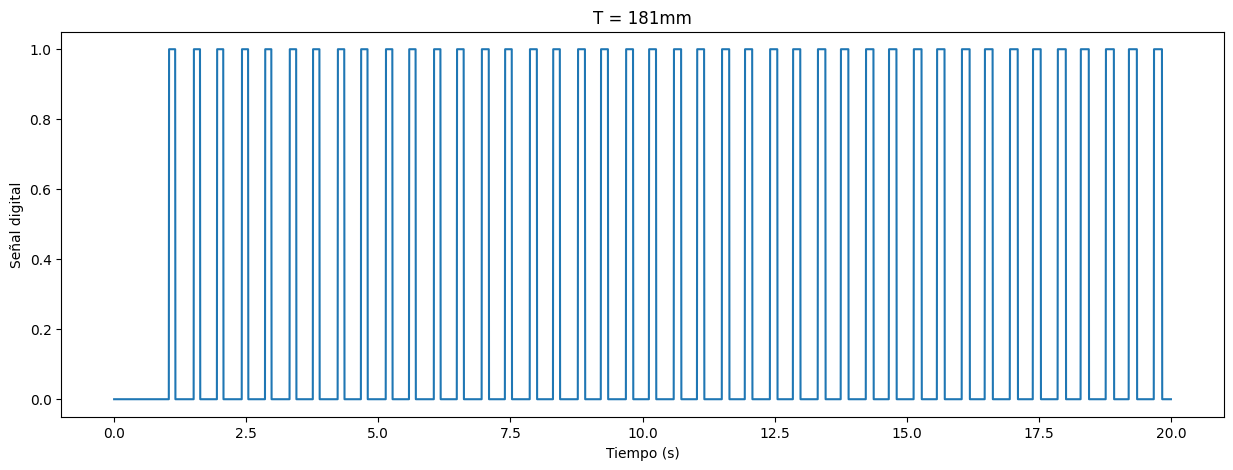

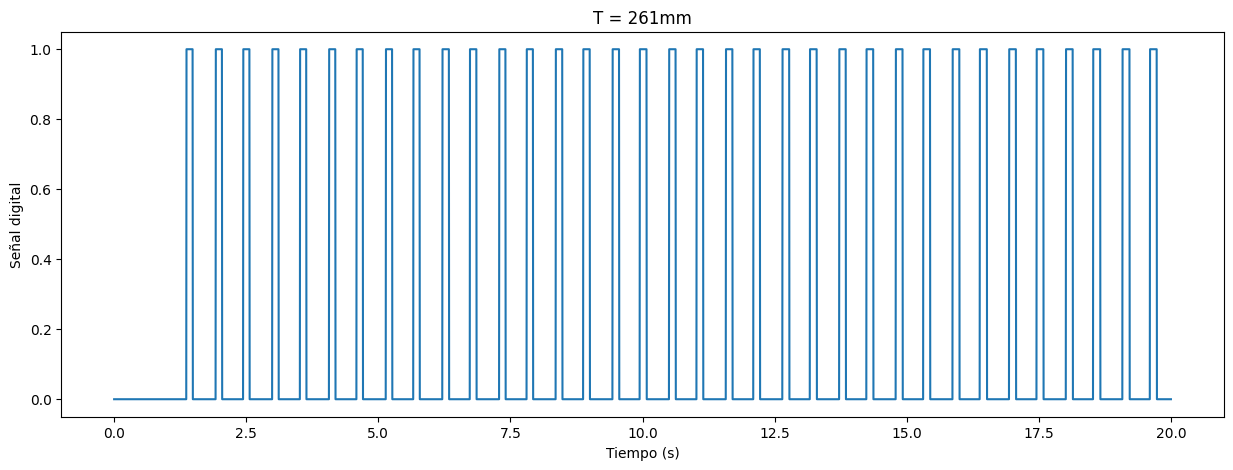

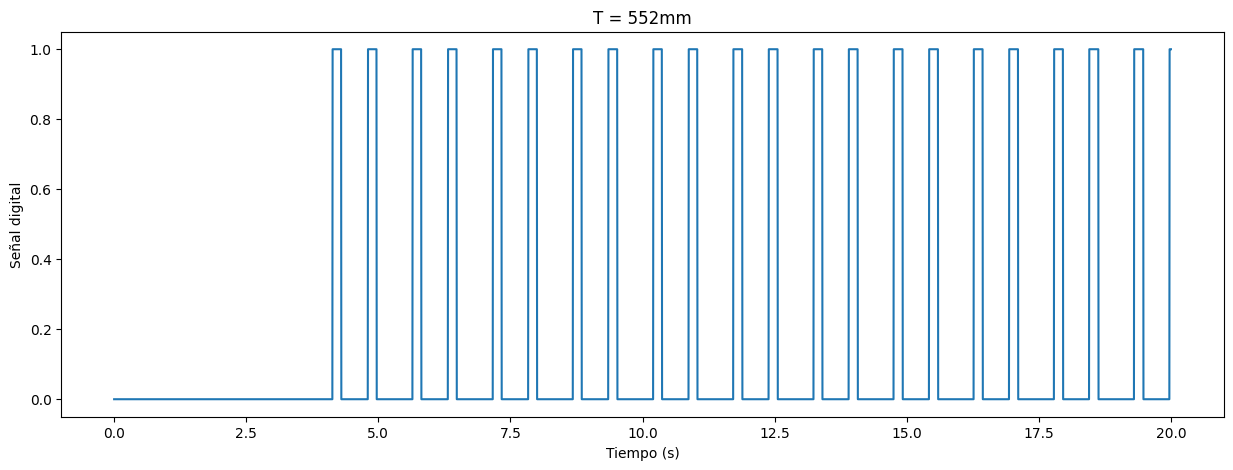

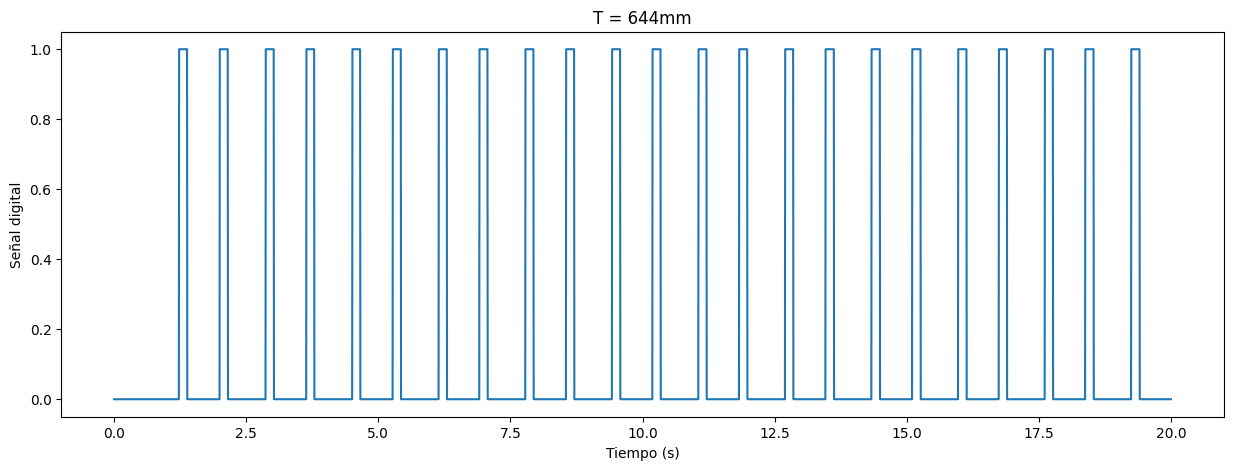

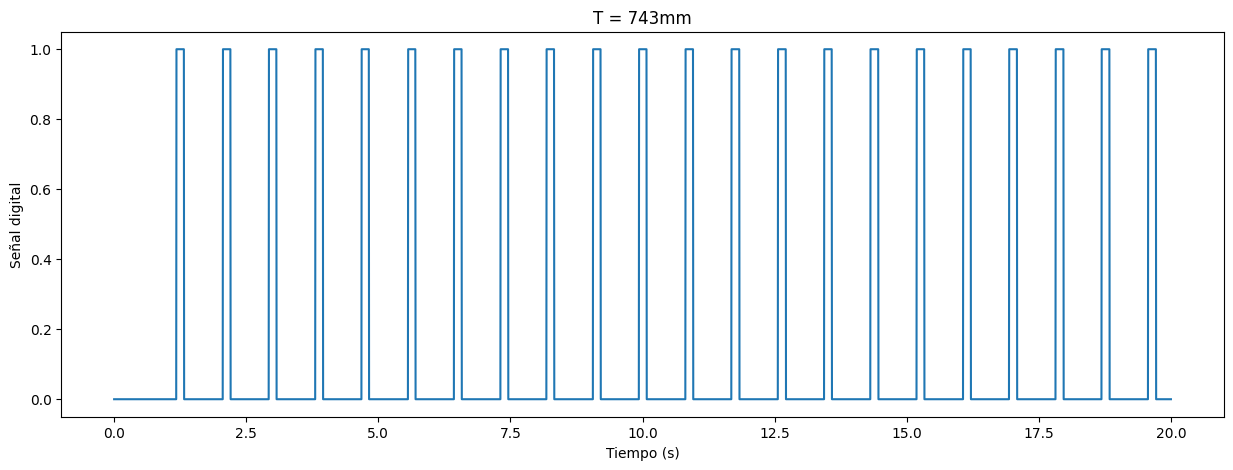

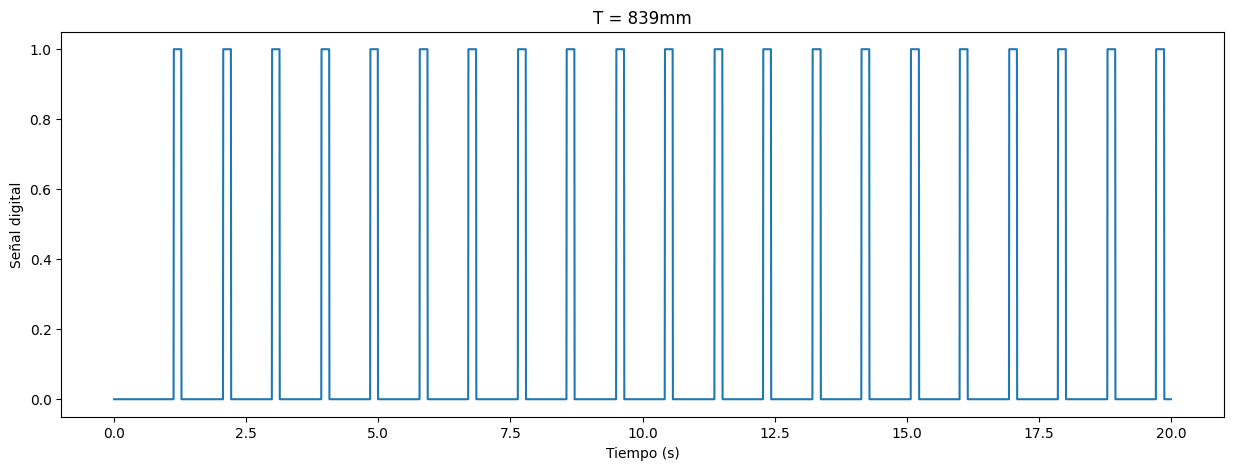

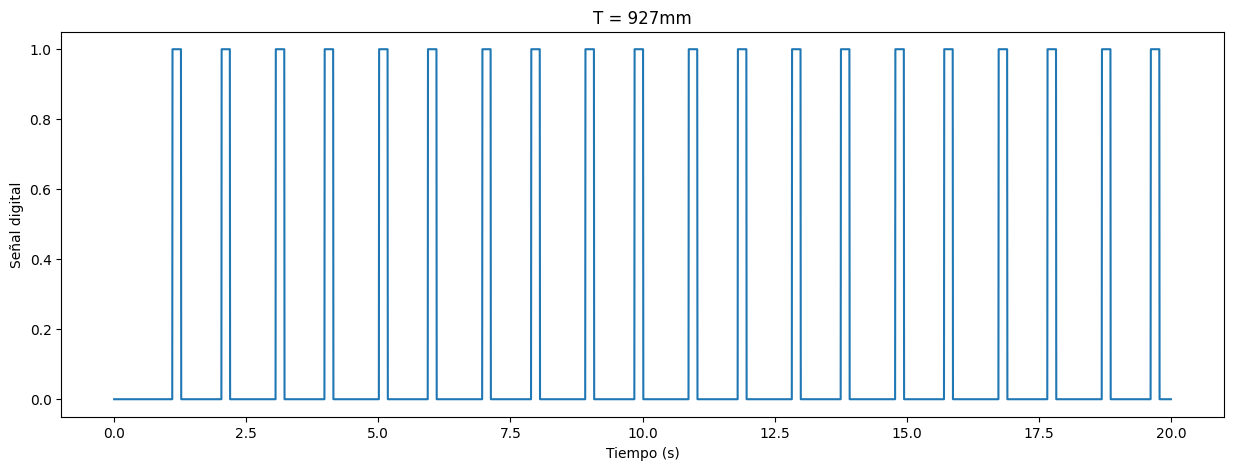

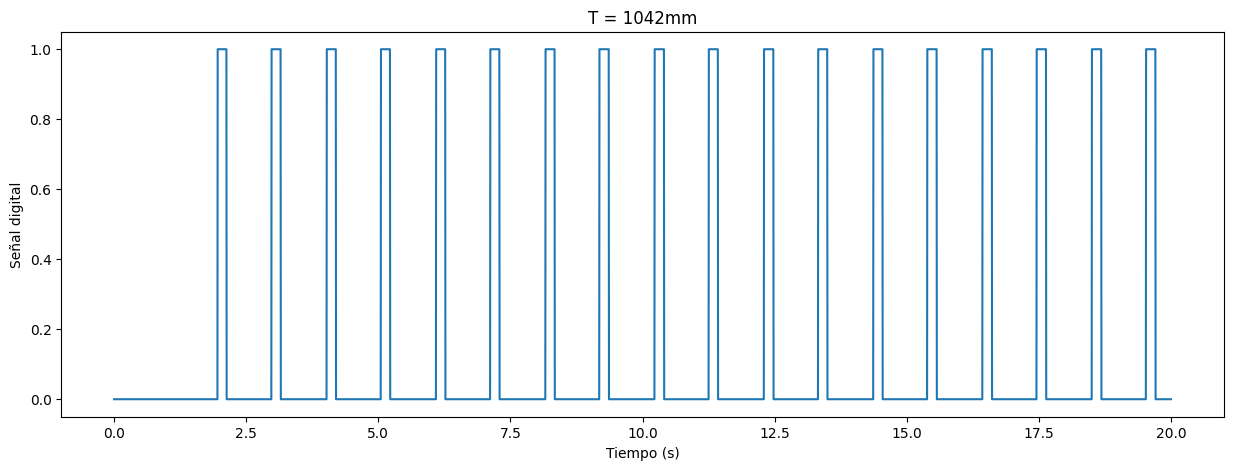

In [ ]:
# Duplico y digitalizo cada columna: Si V es mayor a 3, entonces 1, sino 0
df_digital = df.apply(lambda x: x > 3).astype(int)

# Señales digitales
for c in columns:
    plt.figure(figsize=(15,5))
    df_digital[c].plot()
    plt.title(f"T = {c}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Señal digital")
    plt.show()

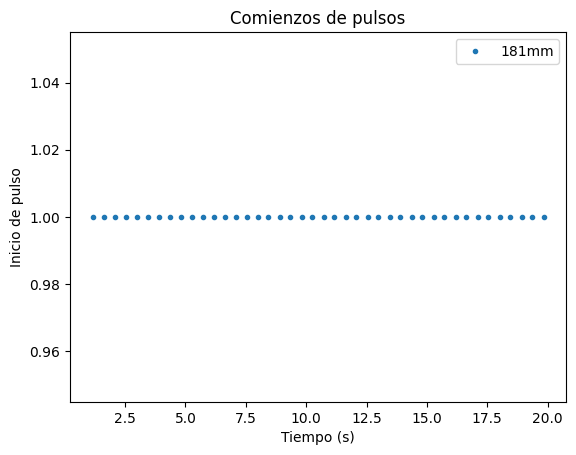

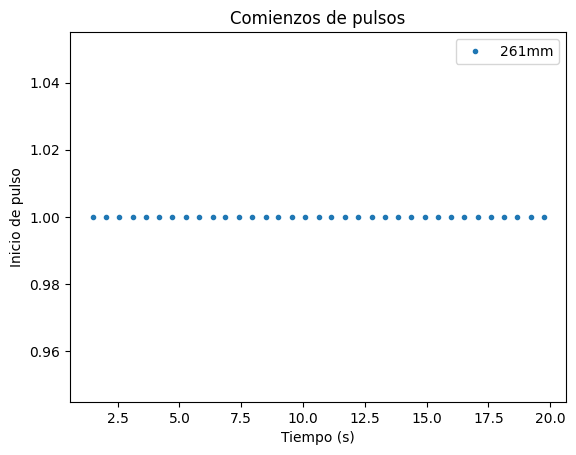

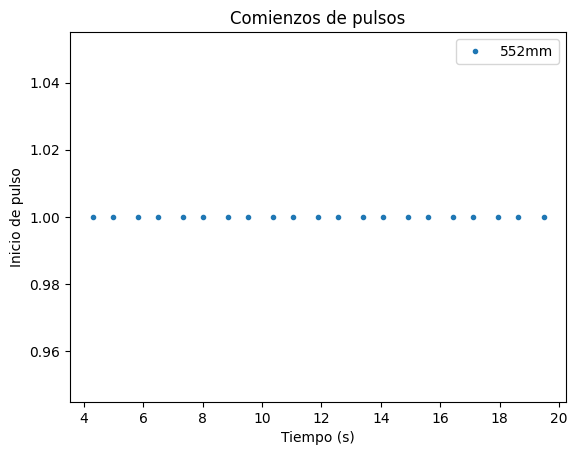

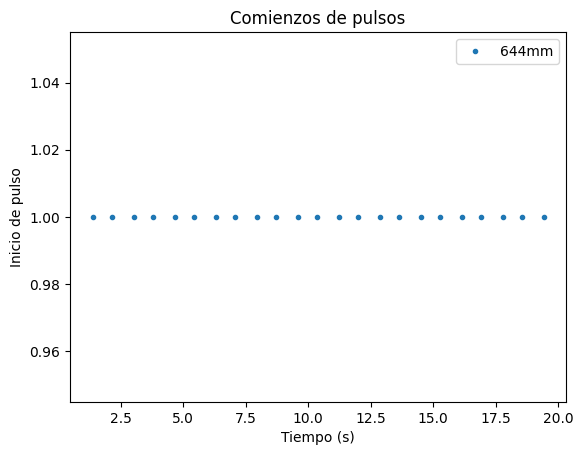

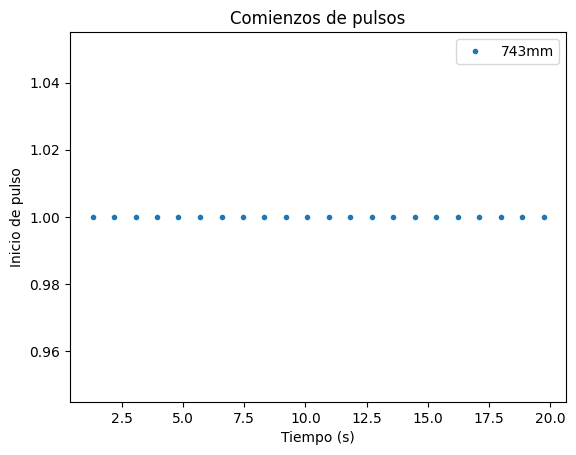

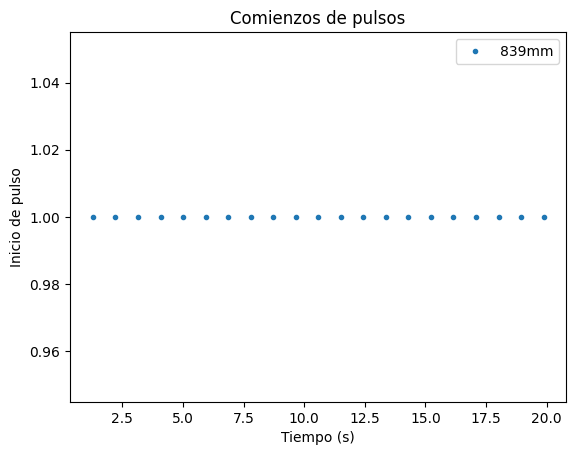

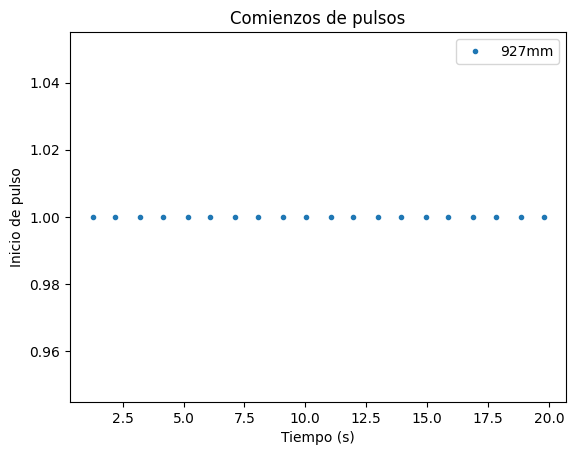

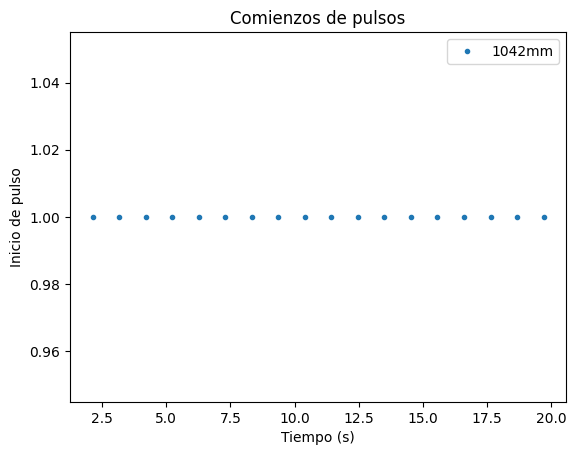

In [ ]:
# Creo lista de dataframes solo con los comienzos de cada pulso
starts_dfs = [df_digital[c].diff().apply(lambda x: x == -1).astype(int) for c in columns]

# Borro filas con zeros de cada df
starts_dfs = [df[df == 1].dropna() for df in starts_dfs]

for s in starts_dfs:
    s.plot(style='.')
    plt.title("Comienzos de pulsos")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Inicio de pulso")
    plt.legend()
    plt.show()

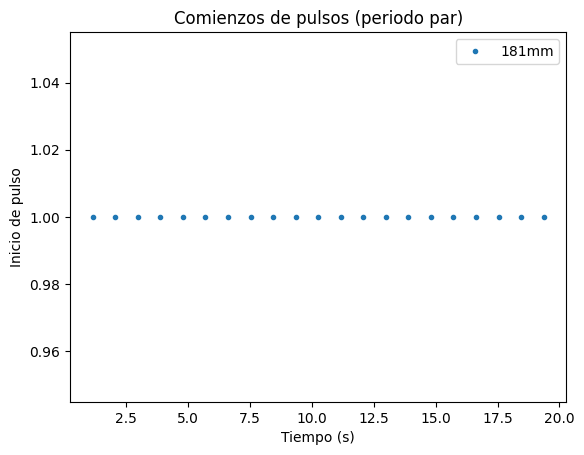

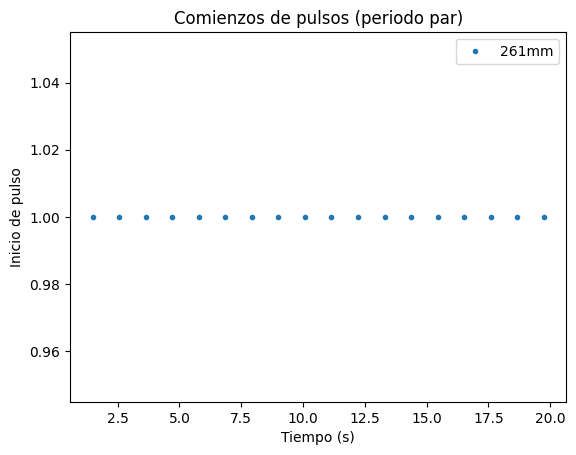

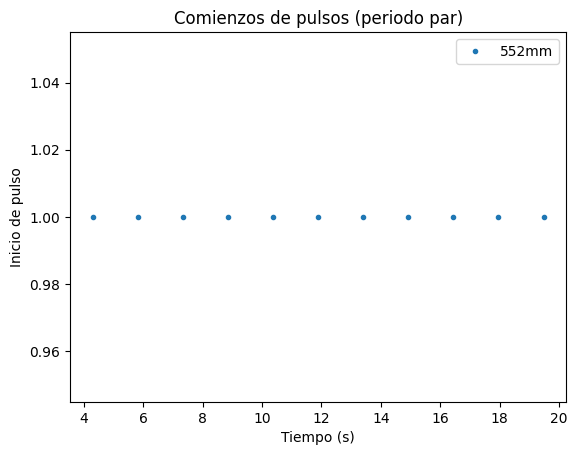

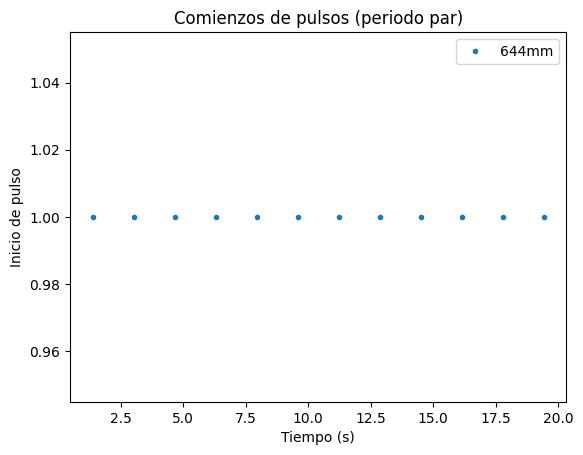

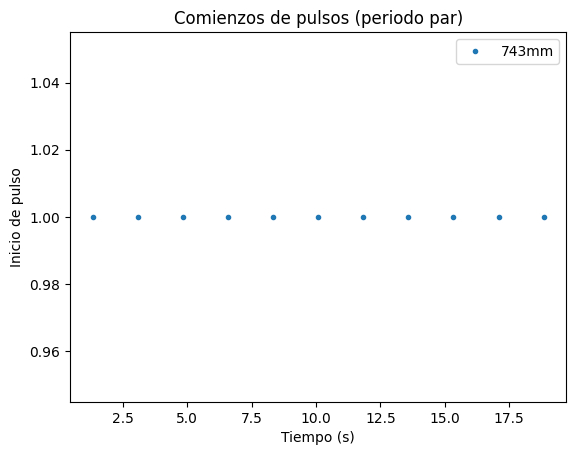

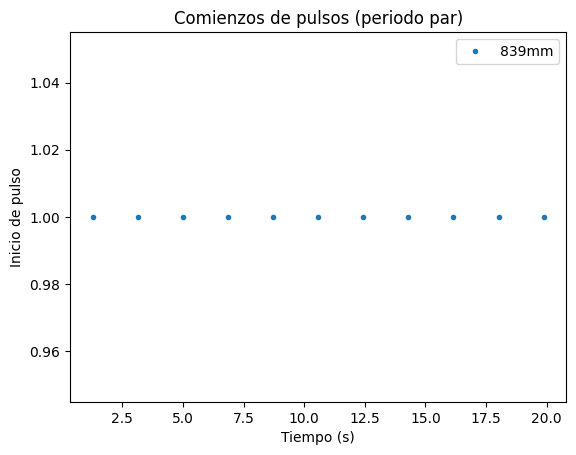

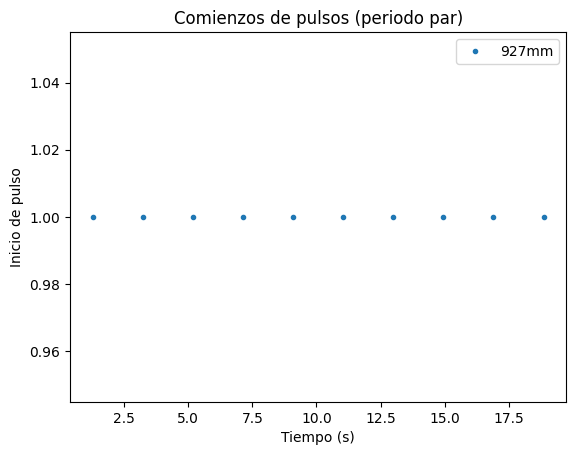

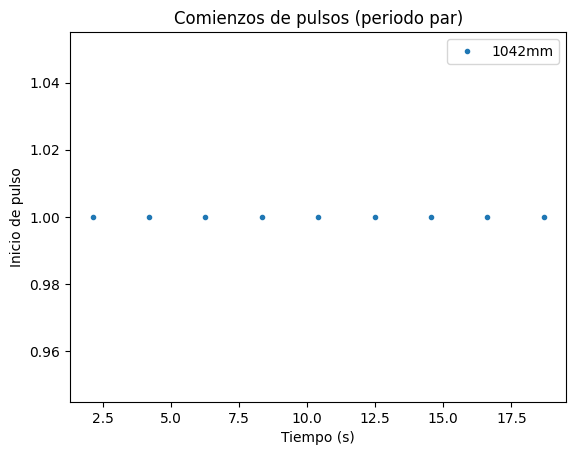

In [ ]:
# Separo filas pares e impares
even_period_dfs = [df.iloc[::2] for df in starts_dfs]
odd_period_dfs = [df.iloc[1::2] for df in starts_dfs]


for p in even_period_dfs:
    p.plot(style='.')
    plt.title("Comienzos de pulsos (periodo par)")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Inicio de pulso")
    plt.legend()

    plt.show()

In [ ]:
# Convierto index como columna de tiempo
even_period_dfs = [df.reset_index(inplace=False) for df in even_period_dfs]
odd_period_dfs = [df.reset_index(inplace=False) for df in odd_period_dfs]


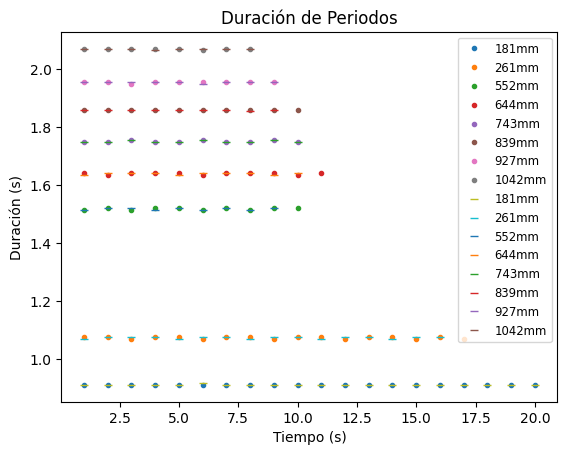

In [ ]:
for i in range(len(even_period_dfs)):
    even_period_dfs[i]['time'].diff().plot(style='.')

for i in range(len(odd_period_dfs)):
    odd_period_dfs[i]['time'].diff().plot(style='_')

plt.title("Duración de Periodos")
plt.xlabel("Tiempo (s)")
plt.ylabel("Duración (s)")
plt.legend(columns+columns, fontsize='small')
plt.show()

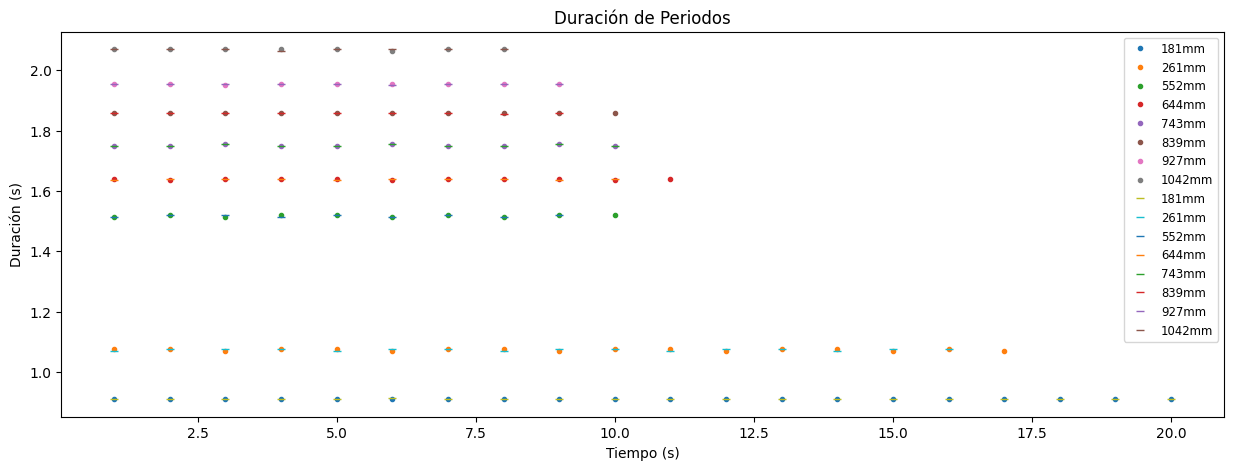

In [ ]:

plt.figure(figsize=(15,5))

for i in range(len(even_period_dfs)):
    even_period_dfs[i]['time'].diff().plot(style='.')

for i in range(len(odd_period_dfs)):
    odd_period_dfs[i]['time'].diff().plot(style='_')

plt.title("Duración de Periodos")
plt.xlabel("Tiempo (s)")
plt.ylabel("Duración (s)")
plt.legend(columns+columns, fontsize='small')
plt.show()

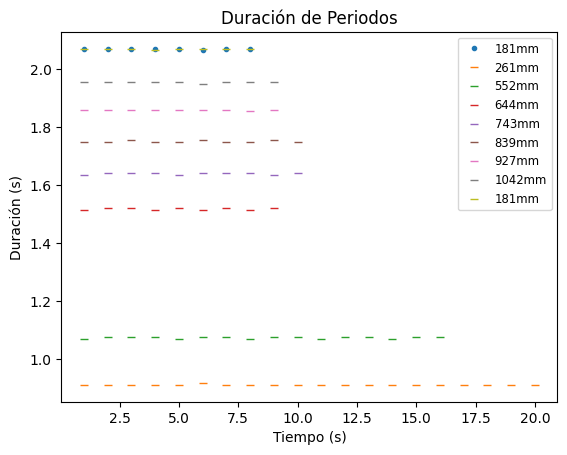

In [ ]:
even_period_dfs[i]['time'].diff().plot(style='.')

for i in range(len(odd_period_dfs)):
    odd_period_dfs[i]['time'].diff().plot(style='_')

plt.title("Duración de Periodos")
plt.xlabel("Tiempo (s)")
plt.ylabel("Duración (s)")
plt.legend(columns+columns, fontsize='small')
plt.show()

In [ ]:
def get_values(even_df, odd_df):
    return list(even_df['time'].diff().dropna().values) + list(odd_df['time'].diff().dropna().values)

/tmp/ipykernel_447258/3967708373.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  boxplot_df = pd.concat([boxplot_df, data], ignore_index=True)


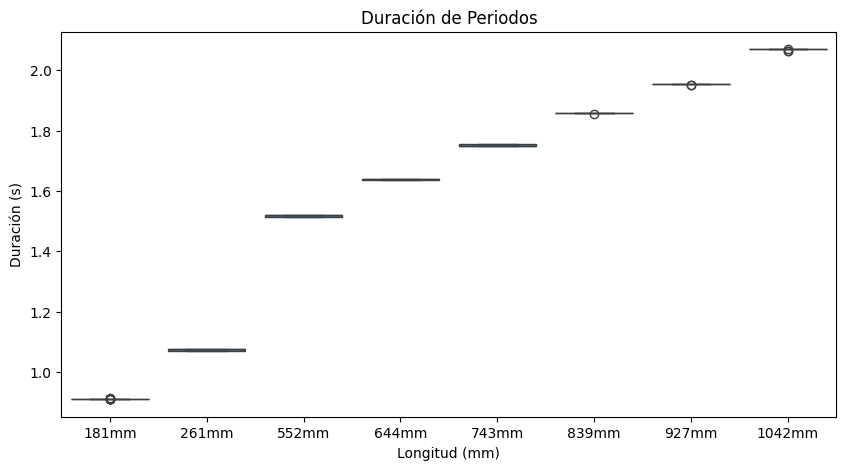

In [ ]:

plt.figure(figsize=(10,5))
plt.title("Duración de Periodos")
plt.xlabel("Longitud (mm)")
plt.ylabel("Duración (s)")

boxplot_df = pd.DataFrame(columns=['Pendulo', 'Periodo'])

for i in range(len(even_period_dfs)):
    data = np.array(get_values(even_period_dfs[i], odd_period_dfs[i]))
    data = pd.DataFrame({'Pendulo': columns[i], 'Periodo': data})
    boxplot_df = pd.concat([boxplot_df, data], ignore_index=True)

sns.boxplot(data=boxplot_df, x="Pendulo", y="Periodo")

plt.show()

In [ ]:
duraciones = [get_values(even_df, odd_df) for even_df, odd_df in zip(even_period_dfs, odd_period_dfs)]

period_means = [np.mean(d) for d in duraciones]
period_stds = [np.std(d) for d in duraciones]
period_amounts = [len(d) for d in duraciones]

g_real = 9.79748

errores = []
errores_porcentuales = []
longitudes = []
periodos = []
periodos_ideales = []

for c, T_est, s, a in zip(columns, period_means, period_stds, period_amounts):
    print(f"L = {c} - {a} mediciones")
    print(f"Periodo medio:   {T_est:.6f}")
    print(f"Desvio estandar: {s:.6f}")
    L = float(c.replace("mm", "")) / 1000

    T_ideal = 2 * np.pi * np.sqrt(L / g_real)
    
    # Local gravity https://www.sensorsone.com/local-gravity-calculator/#local-gravity
    print(f"Periodo esperado: {T_ideal:.6f}")

    error = abs(T_ideal - T_est)
    error_porcentual = error / T_ideal * 100
    print(f"Error: {error:.6f}")
    print(f"Error: {error_porcentual:.6f}%")
    errores.append(error)
    errores_porcentuales.append(error_porcentual)
    longitudes.append(L)
    periodos.append(T_est)
    periodos_ideales.append(T_ideal)
    print("-"*50)


L = 181mm - 40 mediciones
Periodo medio:   0.910125
Desvio estandar: 0.000781
Periodo esperado: 0.854008
Error: 0.056117
Error: 6.571010%
--------------------------------------------------
L = 261mm - 33 mediciones
Periodo medio:   1.073333
Desvio estandar: 0.002357
Periodo esperado: 1.025517
Error: 0.047816
Error: 4.662641%
--------------------------------------------------
L = 552mm - 19 mediciones
Periodo medio:   1.517895
Desvio estandar: 0.002469
Periodo esperado: 1.491393
Error: 0.026501
Error: 1.776952%
--------------------------------------------------
L = 644mm - 21 mediciones
Periodo medio:   1.638571
Desvio estandar: 0.002259
Periodo esperado: 1.610889
Error: 0.027682
Error: 1.718458%
--------------------------------------------------
L = 743mm - 20 mediciones
Periodo medio:   1.751500
Desvio estandar: 0.002291
Periodo esperado: 1.730283
Error: 0.021217
Error: 1.226229%
--------------------------------------------------
L = 839mm - 19 mediciones
Periodo medio:   1.859737
Des

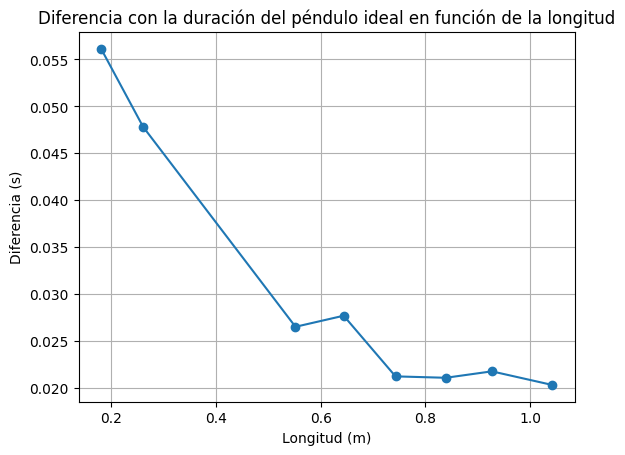

In [ ]:
plt.plot(longitudes, errores, '-o')
plt.xlabel("Longitud (m)")
plt.ylabel("Diferencia (s)")
plt.title("Diferencia con la duración del péndulo ideal en función de la longitud")
plt.grid()
# Add vertical line and xtick in x axis at each x point value
#plt.xticks(longitudes)

plt.show()


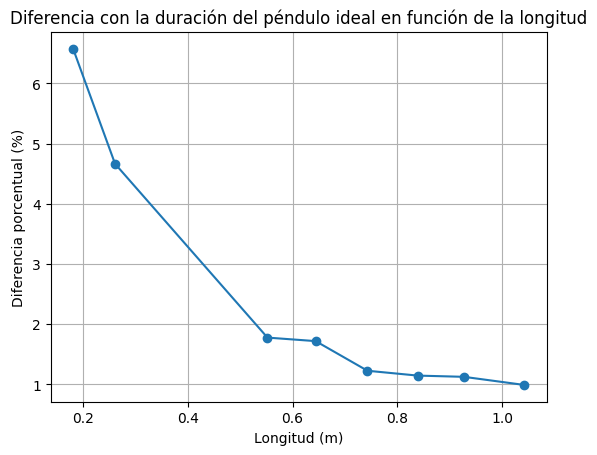

In [ ]:
plt.plot(longitudes, errores_porcentuales, '-o')
plt.xlabel("Longitud (m)")
plt.ylabel("Diferencia porcentual (%)")
plt.title("Diferencia con la duración del péndulo ideal en función de la longitud")
plt.grid()
# Add vertical line and xtick in x axis at each x point value
#plt.xticks(longitudes)

plt.show()

In [ ]:
# 2 A
#Veamos Ta incerteza en la longitud del hilo T y el periodo T

def deltaL(L):  # no considera errores estadísticos
    return 0.001 # error instrumental de 1 mm

error_nominal_T = np.sqrt(2) * 1/200

def deltaT(desv, n):
    return np.sqrt(error_nominal_T ** 2 + (desv / np.sqrt(n)) ** 2)

incertezas = pd.DataFrame(columns=['L', 'dL', 'T', 'dT'])
for c, T, s, n, L in zip(columns, period_means, period_stds, period_amounts, longitudes):
    incertezas.loc[len(incertezas)] = [L, deltaL(L), T, deltaT(s, n)]

incertezas

,L,dL,T,dT
0,0.181,0.001,0.910125,0.007072
1,0.261,0.001,1.073333,0.007083
2,0.552,0.001,1.517895,0.007094
3,0.644,0.001,1.638571,0.007088
4,0.743,0.001,1.751500,0.007090
5,0.839,0.001,1.859737,0.007076
6,0.927,0.001,1.954444,0.007081
7,1.042,0.001,2.069375,0.007083


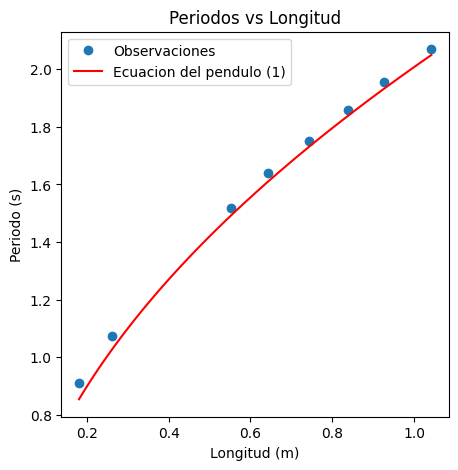

In [ ]:
# 2 B

plt.figure(figsize=(5,5))
plt.title("Periodos vs Longitud")
plt.xlabel("Longitud (m)")
plt.ylabel("Periodo (s)")

plt.plot(incertezas['L'], incertezas['T'], 'o', label='Observaciones')

x_values = np.linspace(min(incertezas['L']), max(incertezas['L']), 100)

def ecuacion_del_pendulo(l):
    return 2 * np.pi * np.sqrt(l/g_real)

plt.plot(x_values, ecuacion_del_pendulo(x_values), color='red', label='Ecuacion del pendulo (1)')

plt.legend()

plt.show()


In [ ]:
# 2 C

def delta_sqrtL(sqrt_L, dL):
    return 1 / (2 * sqrt_L) * dL

incertezas['sqrt_L'] = incertezas.apply(lambda row: np.sqrt(row['L']), axis=1)
incertezas['d_sqrt_L'] = incertezas.apply(lambda row: delta_sqrtL(row['sqrt_L'], row['dL']), axis=1)

incertezas

,L,dL,T,dT,sqrt_L,d_sqrt_L
0,0.181,0.001,0.910125,0.007072,0.425441,0.001175
1,0.261,0.001,1.073333,0.007083,0.510882,0.000979
2,0.552,0.001,1.517895,0.007094,0.742967,0.000673
3,0.644,0.001,1.638571,0.007088,0.802496,0.000623
4,0.743,0.001,1.751500,0.007090,0.861974,0.000580
5,0.839,0.001,1.859737,0.007076,0.915969,0.000546
6,0.927,0.001,1.954444,0.007081,0.962808,0.000519
7,1.042,0.001,2.069375,0.007083,1.020784,0.000490


In [ ]:
def error_relativo(dX, X):
    return dX / X

def mayorError(df):
    res = []
    erroresRelativosT = []
    erroresRelativos_sqrt_L = []

    for index, row in df.iterrows():
        errorRelativoT = error_relativo(row['dT'], row['T'])
        errorRelativo_sqrt_L = error_relativo(row['d_sqrt_L'], row['sqrt_L'])

        if errorRelativoT > errorRelativo_sqrt_L:
            res.append("T")
        else:
            res.append("sqrt_L")

        erroresRelativosT.append(errorRelativoT)
        erroresRelativos_sqrt_L.append(errorRelativo_sqrt_L)

    return (res, erroresRelativosT, erroresRelativos_sqrt_L)


res, erroresRelativosT, erroresRelativos_sqrt_L = mayorError(incertezas)

print(erroresRelativosT)

print(erroresRelativos_sqrt_L)

print(res)



[0.007770520492031402, 0.006599032884719822, 0.0046733884655677585, 0.00432585747239047, 0.0040477334094059835, 0.0038046809971620734, 0.0036229020834385385, 0.003422841122513785]
[0.0027624309392265197, 0.0019157088122605363, 0.0009057971014492752, 0.0007763975155279504, 0.0006729475100942128, 0.0005959475566150178, 0.0005393743257820928, 0.00047984644913627654]
['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T']


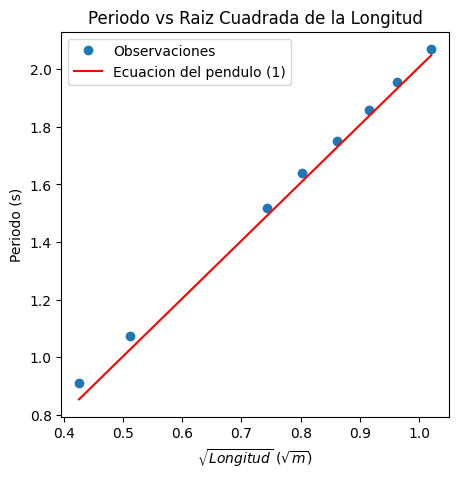

In [ ]:
plt.figure(figsize=(5,5))
plt.title("Periodo vs Raiz Cuadrada de la Longitud")
plt.xlabel((r"$\sqrt{ {Longitud}}$ ($\sqrt{m}$)"))
plt.ylabel("Periodo (s)")

plt.plot(incertezas['sqrt_L'], incertezas['T'], 'o', label='Observaciones')

x_values = np.linspace(min(incertezas['sqrt_L']), max(incertezas['sqrt_L']), 100)

def ecuacion_del_pendulo_2(sqrt_l):
    return 2 * np.pi * sqrt_l / np.sqrt(g_real)

plt.plot(x_values, ecuacion_del_pendulo_2(x_values), color='red', label='Ecuacion del pendulo (1)')

plt.legend()

plt.show()



In [ ]:
# 2 D

def delta_T2(T2, dT):
    return 2 * T2 * dT

incertezas['T2'] = incertezas.apply(lambda row: row['T']**2, axis=1)
incertezas['d_T2'] = incertezas.apply(lambda row: delta_T2(row['T2'], row['dT']), axis=1)

incertezas



,L,dL,T,dT,sqrt_L,d_sqrt_L,T2,d_T2
0,0.181,0.001,0.910125,0.007072,0.425441,0.001175,0.828328,0.011716
1,0.261,0.001,1.073333,0.007083,0.510882,0.000979,1.152044,0.016320
2,0.552,0.001,1.517895,0.007094,0.742967,0.000673,2.304004,0.032688
3,0.644,0.001,1.638571,0.007088,0.802496,0.000623,2.684916,0.038063
4,0.743,0.001,1.751500,0.007090,0.861974,0.000580,3.067752,0.043498
5,0.839,0.001,1.859737,0.007076,0.915969,0.000546,3.458621,0.048944
6,0.927,0.001,1.954444,0.007081,0.962808,0.000519,3.819853,0.054095
7,1.042,0.001,2.069375,0.007083,1.020784,0.000490,4.282313,0.060664


In [ ]:
def mayorError2(df):
    res = []
    erroresRelativosT2 = []
    erroresRelativos_L = []

    for index, row in df.iterrows():
        errorRelativoT2 = error_relativo(row['d_T2'], row['T2'])
        errorRelativo_L = error_relativo(row['dL'], row['L'])

        if errorRelativoT2 > errorRelativo_L:
            res.append("T2")
        else:
            res.append("L")

        erroresRelativosT2.append(errorRelativoT2)
        erroresRelativos_L.append(errorRelativo_L)

    return (res, erroresRelativosT2, erroresRelativos_L)


res, erroresRelativosT2, erroresRelativos_L = mayorError2(incertezas)

print(erroresRelativosT2)

print(erroresRelativos_L)

print(res)



[0.014144289925620161, 0.01416592392586522, 0.014187423510207804, 0.014176452916662485, 0.01417921013314916, 0.014151410845760196, 0.014161521699485306, 0.014166283695803927]
[0.005524861878453039, 0.0038314176245210726, 0.0018115942028985505, 0.0015527950310559005, 0.0013458950201884253, 0.001191895113230036, 0.0010787486515641855, 0.0009596928982725527]
['T2', 'T2', 'T2', 'T2', 'T2', 'T2', 'T2', 'T2']


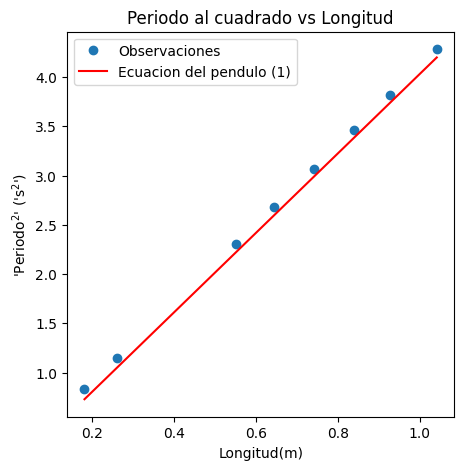

In [ ]:
plt.figure(figsize=(5,5))
plt.title("Periodo al cuadrado vs Longitud")
plt.xlabel(("Longitud(m)"))
plt.ylabel((r"'Periodo$^2$' ('s$^2$')"))

plt.plot(incertezas['L'], incertezas['T2'], 'o', label='Observaciones')


x_values = np.linspace(min(incertezas['L']), max(incertezas['L']), 100)

def ecuacion_del_pendulo_3(L):
    return 4 * np.pi**2 * L / g_real

plt.plot(x_values, ecuacion_del_pendulo_3(x_values), color='red', label='Ecuacion del pendulo (1)')

plt.legend()

plt.show()


## Ajustes Lineales

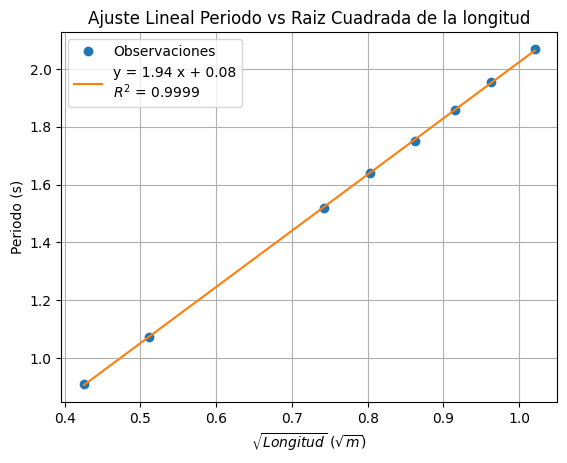

Valor de g = 10.4362876293963 +- 0.13499788363257148


In [ ]:
# 2 E

def lineal(x, a, b):
    return a * x + b

def fit_with_curve_fit(lineal, x, y, y_err):
    popt, pconv = curve_fit(lineal, x, y, sigma=y_err, absolute_sigma=True)
    return popt[0], popt[1], np.sqrt(pconv.diagonal())[0], np.sqrt(pconv.diagonal())[1]

a, b, da, db = fit_with_curve_fit(lineal, incertezas['sqrt_L'], incertezas['T'], incertezas['dT'])

R2 = 1 - np.sum((lineal(incertezas['sqrt_L'], a, b) - incertezas['T'])**2) / np.sum((incertezas['T'] - np.mean(incertezas['T']))**2)

plt.plot(incertezas['sqrt_L'], incertezas['T'], 'o', label='Observaciones')

plt.plot(incertezas['sqrt_L'], lineal(incertezas['sqrt_L'], a, b), label=f"y = {a:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")

plt.xlabel((r"$\sqrt{ {Longitud}}$ ($\sqrt{m}$)"))
plt.ylabel("Periodo (s)")
plt.title("Ajuste Lineal Periodo vs Raiz Cuadrada de la longitud")
plt.legend()
plt.grid()
plt.show()


# calculemos g
g1 = 4*np.pi**2/a**2
dg1 = 8*np.pi**2/a**3 * da
print(f"Valor de g = {g1} +- {dg1}")

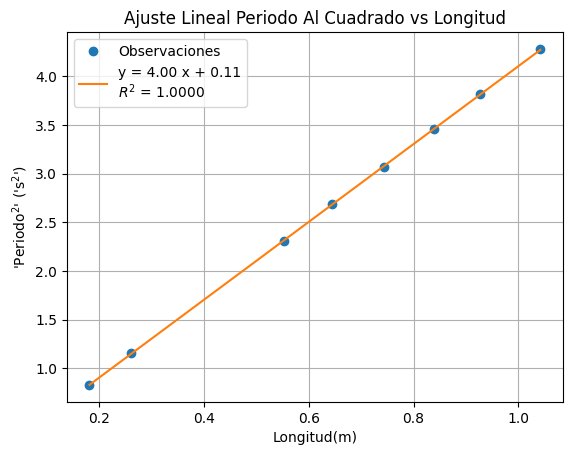

Valor de g = 9.870932882144295 +- 0.09005831098215575


In [ ]:
a, b, da, db = fit_with_curve_fit(lineal, incertezas['L'], incertezas['T2'], incertezas['d_T2'])

R2 = 1 - np.sum((lineal(incertezas['L'], a, b) - incertezas['T2'])**2) / np.sum((incertezas['T2'] - np.mean(incertezas['T2']))**2)

plt.plot(incertezas['L'], incertezas['T2'], 'o', label='Observaciones')

plt.plot(incertezas['L'], lineal(incertezas['L'], a, b), label=f"y = {a:.2f} x + {b:.2f}\n"+r"$R^2$"+f" = {R2:.4f}")

plt.xlabel(("Longitud(m)"))
plt.ylabel((r"Periodo$^2$ (s$^2$)"))
plt.title("Ajuste Lineal Periodo Al Cuadrado vs Longitud")
plt.legend()
plt.grid()
plt.show()

# calculemos g
g2 = 4*np.pi**2/a
dg2 = 4*np.pi**2/a**2 * da
print(f"Valor de g = {g2} +- {dg2}")